In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [30]:
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime
import platform
import gala
import astropy
from astropy.coordinates import CartesianRepresentation, CartesianDifferential
from sklearn.decomposition import PCA
from scipy.ndimage import uniform_filter1d
from sklearn.metrics import r2_score
from scipy.stats import f_oneway
from scipy.fft import rfft, rfftfreq
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D

from gala.units import galactic
from gala.potential import Hamiltonian
from gala.potential import LogarithmicPotential
from gala.dynamics import PhaseSpacePosition
from gala.dynamics.mockstream import (
    MockStreamGenerator,
    FardalStreamDF
)
from gala.integrate import LeapfrogIntegrator

from tqdm.notebook import tqdm
import time
from mpl_toolkits.mplot3d import Axes3D

from modules.generate_streams import *
from modules.stream_analysis import *


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
with open("../data/gc_stream_ensemble.pkl", "rb") as f:
    data = pickle.load(f)

streams = data["streams"]

## 00. Sanity Check : Time Convention

In [4]:
for i, s in enumerate(streams):

    print(f"\nProcessing stream {i} ({s['halo']})")
    
    # ----------------------------------
    # Extract present-day stream snapshot
    # ----------------------------------
    stream_snapshot = StellarStreamSimulator.extract_stream_snapshot(
        s["stream"],
        s["t"],
        time_index=0 
    )

    assert np.allclose(stream_snapshot.pos.xyz.mean(axis=1),
                   s["orbit"][0].pos.xyz,
                   atol=0.1 * u.kpc)


Processing stream 0 (spherical)

Processing stream 1 (spherical)

Processing stream 2 (spherical)

Processing stream 3 (oblate)

Processing stream 4 (oblate)

Processing stream 5 (oblate)

Processing stream 6 (prolate)

Processing stream 7 (prolate)

Processing stream 8 (prolate)


## 01. Orbital Diagnosis :

A) Stream–plane misalignment \
B) Orbital plane precession \
C) Thickness evolution \
D) Oscillation amplitude (FFT)

In [5]:
#StreamDiagnostics.compute_theta_plane()
#StreamDiagnostics.compute_precession_curve()

In [8]:
results = []

In [9]:
for i, s in enumerate(streams):

    print(f"\nProcessing stream {i} ({s['halo']})")

    # ----------------------------------
    # 1. Hamiltonian
    # ----------------------------------
    H = StellarStreamSimulator._make_hamiltonian(q=s["q"])

    # ----------------------------------
    # 2. Present-day snapshot
    # ----------------------------------
    stream_snapshot = StellarStreamSimulator.extract_stream_snapshot(
        s["stream"],
        s["t"],
        time_index=0
    )

    n_particles = stream_snapshot.pos.x.shape[0]
    print(f"Particles: {n_particles}")

    # ----------------------------------
    # 3. Time grid (forward evolution)
    # ----------------------------------
    t_array = np.arange(-4000, 0, 20) * u.Myr
    t_Gyr = t_array.to_value(u.Gyr)

    # ----------------------------------
    # 4. Integrate stream + orbit
    # ----------------------------------
    stream_orbits = H.integrate_orbit(
        stream_snapshot,
        t=t_array,
        Integrator=LeapfrogIntegrator
    )

    prog_present = s["orbit"][0]

    orbit = H.integrate_orbit(
        prog_present,
        t=t_array,
        Integrator=LeapfrogIntegrator
    )

    # ======================================================
    # A) Stream–Plane Misalignment
    # ======================================================
    
    theta_plane = StreamDiagnostics.compute_theta_plane(stream_orbits, orbit)
    
    # ======================================================
    # B) Orbital Precession
    # ======================================================
    
    delta_L = StreamDiagnostics.compute_precession_curve(orbit)

    # ======================================================
    # C) Thickness Diagnostics
    # ======================================================
    
    sigma_perp, sigma_parallel = StreamDiagnostics.compute_thickness_curve(stream_orbits)

    # Late-time growth slope (-2 to 0 Gyr)
    late_mask = t_Gyr >= -2.0
    thickness_slope = np.polyfit(
        t_Gyr[late_mask],
        sigma_perp[late_mask],
        1
    )[0]

    # Elongation ratio (late time mean)
    elongation_ratio = np.mean(
        sigma_parallel[late_mask] / sigma_perp[late_mask]
    )

    # ======================================================
    # D) Oscillation Diagnostics
    # ======================================================
    
    oscillation_dictionary = StreamDiagnostics.compute_fft_diagnostics(
        theta_plane,
        t_Gyr
    )

    # ======================================================
    # SCALAR METRICS
    # ======================================================

    # Stream–plane metrics
    theta_plane_mean = np.mean(theta_plane)
    theta_plane_max  = np.max(theta_plane)

    # Precession metrics
    precession_max   = np.max(delta_L)
    precession_slope = np.polyfit(
        t_Gyr[late_mask],
        delta_L[late_mask],
        1
    )[0]

    # Oscillation parameters
    osc_amplitude = oscillation_dictionary['dominant_amplitude']
    osc_frequency = oscillation_dictionary['dominant_frequency']
    osc_power = oscillation_dictionary['total_power']

    # ======================================================
    # STORE RESULTS
    # ======================================================
    results.append({
        "halo": s["halo"],
        "q": s["q"],
        "mass": s["mass"].value,

        # Time
        "time_Gyr": t_Gyr,

        # Curves
        "theta_plane": theta_plane,
        "delta_L": delta_L,
        "sigma_perp": sigma_perp,
        "sigma_parallel": sigma_parallel,

        # Primary scalar diagnostics
        "theta_plane_mean": theta_plane_mean,
        "theta_plane_max": theta_plane_max,

        "precession_max": precession_max,
        "precession_slope": precession_slope,

        "thickness_slope": thickness_slope,
        "elongation_ratio": elongation_ratio,

        "oscillation_amp": osc_amplitude,
        "dominant_frequency": osc_frequency,
        "oscillation_power": osc_power,

        "n_particles": n_particles
    })

    # ----------------------------------
    # Console summary
    # ----------------------------------
    print(f"theta_plane_mean   : {theta_plane_mean:.3f}")
    print(f"theta_plane_max   : {theta_plane_max:.3f}")
    print(f"precession_max     : {precession_max:.3f}")
    print(f"precession_slope     : {precession_slope:.3f}")
    print(f"thickness_slope    : {thickness_slope:.5f}")
    print(f"elongation_ratio   : {elongation_ratio:.3f}")
    print(f"osc_amp            : {osc_amplitude:.3f}")


Processing stream 0 (spherical)
Particles: 3000
theta_plane_mean   : 89.960
theta_plane_max   : 90.000
precession_max     : 0.000
precession_slope     : 0.000
thickness_slope    : 0.15373
elongation_ratio   : 10.051
osc_amp            : 4.059

Processing stream 1 (spherical)
Particles: 3000
theta_plane_mean   : 89.949
theta_plane_max   : 90.000
precession_max     : 0.000
precession_slope     : 0.000
thickness_slope    : 0.18109
elongation_ratio   : 9.238
osc_amp            : 3.668

Processing stream 2 (spherical)
Particles: 3000
theta_plane_mean   : 89.980
theta_plane_max   : 90.000
precession_max     : 0.000
precession_slope     : 0.000
thickness_slope    : 0.26828
elongation_ratio   : 7.921
osc_amp            : 1.698

Processing stream 3 (oblate)
Particles: 3000
theta_plane_mean   : 88.546
theta_plane_max   : 89.999
precession_max     : 71.750
precession_slope     : 20.354
thickness_slope    : 0.17380
elongation_ratio   : 9.285
osc_amp            : 99.984

Processing stream 4 (oblat

## 02. Metrics Diagnostic Plots & Halo Discrimination Test :

In [10]:
df = pd.DataFrame(results)

print(df.head())

        halo    q     mass                                           time_Gyr  \
0  spherical  1.0   8000.0  [-4.0, -3.98, -3.96, -3.94, -3.92, -3.9, -3.88...   
1  spherical  1.0  10000.0  [-4.0, -3.98, -3.96, -3.94, -3.92, -3.9, -3.88...   
2  spherical  1.0  20000.0  [-4.0, -3.98, -3.96, -3.94, -3.92, -3.9, -3.88...   
3     oblate  0.8   8000.0  [-4.0, -3.98, -3.96, -3.94, -3.92, -3.9, -3.88...   
4     oblate  0.8  10000.0  [-4.0, -3.98, -3.96, -3.94, -3.92, -3.9, -3.88...   

                                         theta_plane  \
0  [89.65342938525025, 89.7955472887561, 89.99082...   
1  [89.52641260381992, 89.5173249567068, 89.54517...   
2  [89.85693173562994, 89.84536003950888, 89.8381...   
3  [89.84307454191658, 89.5173823018555, 89.13552...   
4  [89.6622096286325, 89.20901342681668, 88.71579...   

                                             delta_L  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0,

In [11]:
print(df.groupby("halo").size())

halo
oblate       3
prolate      3
spherical    3
dtype: int64


In [12]:
#df.to_csv('../data/full_orbital_dynamics_metrics_diagnostics.csv', index=False)

/Users/vasu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/vasu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/vasu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/vasu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and 

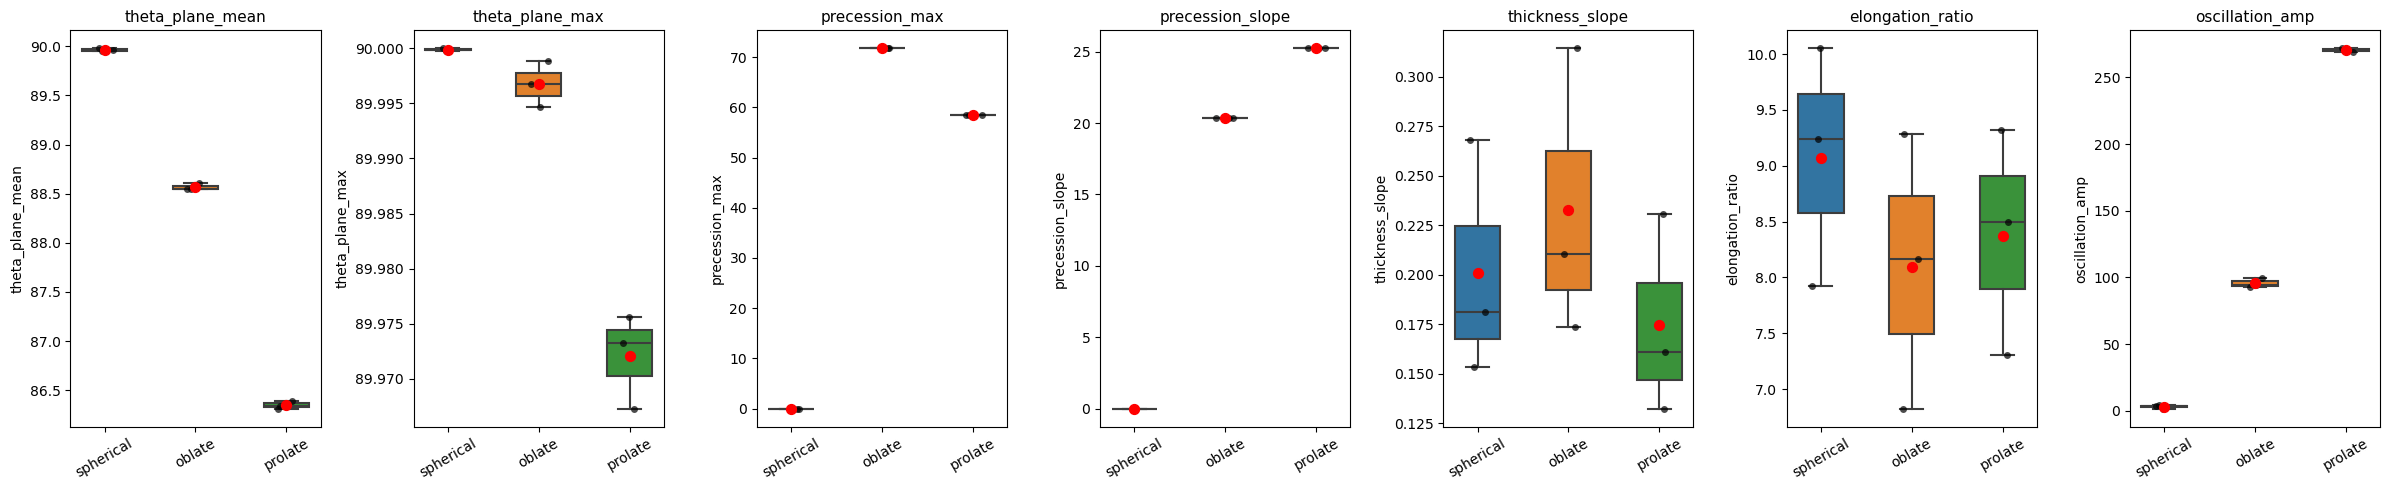

In [13]:
metrics = [
    "theta_plane_mean",
    "theta_plane_max",
    "precession_max",
    "precession_slope",
    "thickness_slope",
    "elongation_ratio",
    "oscillation_amp"
]

halo_order = ["spherical", "oblate", "prolate"]

fig, axes = plt.subplots(1, len(metrics), figsize=(24, 5))

for ax, metric in zip(axes, metrics):

    sns.boxplot(
        data=df,
        x="halo",
        y=metric,
        order=halo_order,
        ax=ax,
        width=0.5,
        showfliers=False
    )

    sns.stripplot(
        data=df,
        x="halo",
        y=metric,
        order=halo_order,
        ax=ax,
        color="black",
        size=5,
        alpha=0.7
    )

    ax.set_title(metric, fontsize=11)
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=30)

    # Optional: show mean marker
    means = df.groupby("halo")[metric].mean().reindex(halo_order)
    for i, mean_val in enumerate(means):
        ax.scatter(i, mean_val, 
                   color="red", 
                   s=50, 
                   zorder=5,
                   label="Mean" if i == 0 else "")

plt.tight_layout()
# plt.savefig('../figures/dynamic_metric_box_plot_metric_comparison', dpi=140)
# plt.close()

/Users/vasu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/vasu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/vasu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/vasu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and 

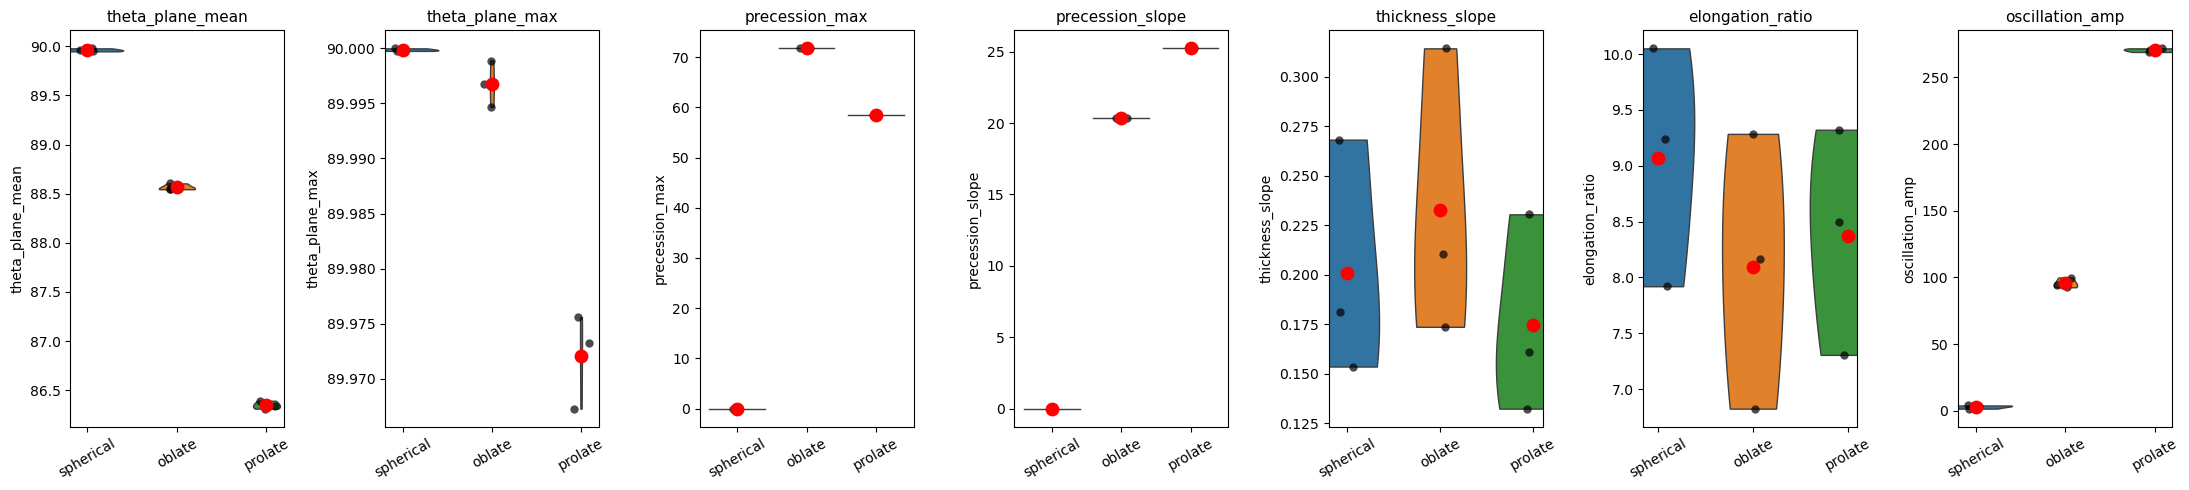

In [14]:
metrics = [
    "theta_plane_mean",
    "theta_plane_max",
    "precession_max",
    "precession_slope",
    "thickness_slope",
    "elongation_ratio",
    "oscillation_amp"
]

halo_order = ["spherical", "oblate", "prolate"]

fig, axes = plt.subplots(1, len(metrics), figsize=(22, 5))

for ax, metric in zip(axes, metrics):

    sns.violinplot(
        data=df,
        x="halo",
        y=metric,
        order=halo_order,
        ax=ax,
        inner=None,
        cut=0,
        linewidth=1
    )

    sns.stripplot(
        data=df,
        x="halo",
        y=metric,
        order=halo_order,
        ax=ax,
        color="black",
        size=6,
        alpha=0.7
    )

    # Overlay mean marker
    means = df.groupby("halo")[metric].mean().reindex(halo_order)

    for i, mean_val in enumerate(means):
        ax.scatter(i, mean_val,
                   color="red",
                   s=80,
                   zorder=5)

    ax.set_title(metric, fontsize=11)
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
# plt.savefig('../figures/dynamic_metric_violin_plot_metric_comparison', dpi=140)
# plt.close()

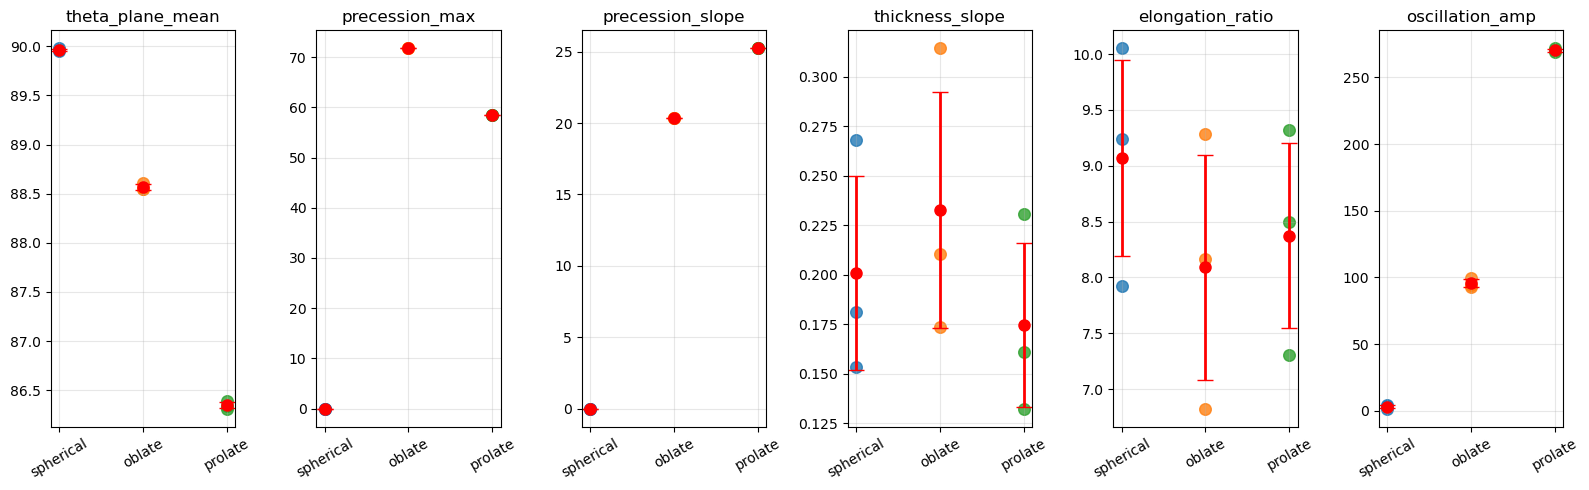

In [15]:
metrics = [
    "theta_plane_mean",
    "precession_max",
    "precession_slope",
    "thickness_slope",
    "elongation_ratio",
    "oscillation_amp",
    
]

halo_order = ["spherical", "oblate", "prolate"]

fig, axes = plt.subplots(1, len(metrics), figsize=(16, 5))

for ax, metric in zip(axes, metrics):

    for i, halo in enumerate(halo_order):

        vals = df[df.halo == halo][metric].values

        mean = vals.mean()
        std = vals.std()

        # Individual points
        ax.scatter(
            np.full_like(vals, i),
            vals,
            s=70,
            alpha=0.8
        )

        # Mean ± std
        ax.errorbar(
            i,
            mean,
            yerr=std,
            fmt="o",
            color="red",
            capsize=6,
            linewidth=2,
            markersize=8
        )

    ax.set_xticks(range(len(halo_order)))
    ax.set_xticklabels(halo_order, rotation=30)
    ax.set_title(metric)
    ax.set_xlabel("")
    ax.grid(alpha=0.3)

plt.tight_layout()
# plt.savefig('../figures/dynamic_metric_dot_plot_metric_comparison', dpi=140)
# plt.close()

In [17]:
#StatisticalDiagnostics.cohens_d()

In [19]:
# Cohen's d

metrics = [
    "theta_plane_mean",
    "precession_max",
    "precession_slope",
    "thickness_slope",
    "elongation_ratio",
    "oscillation_amp",
    
]

pairwise_stats = []

for metric in metrics:
    for h1, h2 in [
        ("spherical","oblate"),
        ("spherical","prolate"),
        ("oblate","prolate")
    ]:
        d = StatisticalDiagnostics.cohens_d(df, metric, h1, h2)
        label = StatisticalDiagnostics.interpret_effect(d)
        
        pairwise_stats.append({
            "metric": metric,
            "comparison": f"{h1} vs {h2}",
            "cohens_d": d,
            "label": label
        })

pairwise_df = pd.DataFrame(pairwise_stats)
print(pairwise_df)

              metric            comparison    cohens_d       label
0   theta_plane_mean   spherical vs oblate   55.032683  very large
1   theta_plane_mean  spherical vs prolate  118.002373  very large
2   theta_plane_mean     oblate vs prolate   60.496882  very large
3     precession_max   spherical vs oblate         inf  very large
4     precession_max  spherical vs prolate         inf  very large
5     precession_max     oblate vs prolate         inf  very large
6   precession_slope   spherical vs oblate         inf  very large
7   precession_slope  spherical vs prolate         inf  very large
8   precession_slope     oblate vs prolate         inf  very large
9    thickness_slope   spherical vs oblate    0.478249       small
10   thickness_slope  spherical vs prolate    0.475862       small
11   thickness_slope     oblate vs prolate    0.928770       large
12  elongation_ratio   spherical vs oblate    0.846519       large
13  elongation_ratio  spherical vs prolate    0.666412    mode

In [127]:
#pairwise_df.to_csv('../data/orbital_dynamics_cohens_d_pairwise_diagnostics.csv', index=False)

In [21]:
# Halo Discrimination Test (ANOVA) & Variance Ratio

metrics = [
    "theta_plane_mean",
    "precession_max",
    "precession_slope",
    "thickness_slope",
    "elongation_ratio",
    "oscillation_amp",   
]

summary_stats = []

for metric in metrics:

    g1 = df[df.halo=="spherical"][metric]
    g2 = df[df.halo=="oblate"][metric]
    g3 = df[df.halo=="prolate"][metric]

    # Skip metric if any group has zero variance AND identical means
    if g1.std() == 0 and g2.std() == 0 and g3.std() == 0:
        F = np.inf
        p_value = 0.0
    else:
        F, p_value = f_oneway(g1, g2, g3)

    summary_stats.append({
        "metric": metric,
        "F_stat": F,
        "p_value": p_value,
        "variance_ratio_R": StatisticalDiagnostics.variance_ratio(df, metric)
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)

             metric        F_stat       p_value  variance_ratio_R
0  theta_plane_mean  1.021787e+04  2.528716e-11      1.021787e+04
1    precession_max           inf  0.000000e+00               inf
2  precession_slope           inf  0.000000e+00               inf
3   thickness_slope  6.688429e-01  5.467344e-01      6.688429e-01
4  elongation_ratio  6.171008e-01  5.705345e-01      6.171008e-01
5   oscillation_amp  9.318620e+03  3.333417e-11      9.318620e+03


In [22]:
#summary_df.to_csv('../data/orbital_dynamics_diagnostics_summary.csv', index=False)

In [ ]:
StatisticalDiagnostics.ensemble_curve()

Text(0.5, 0.98, 'Dynamical Diagnostic Summary: Halo Geometry Imprint on Streams')

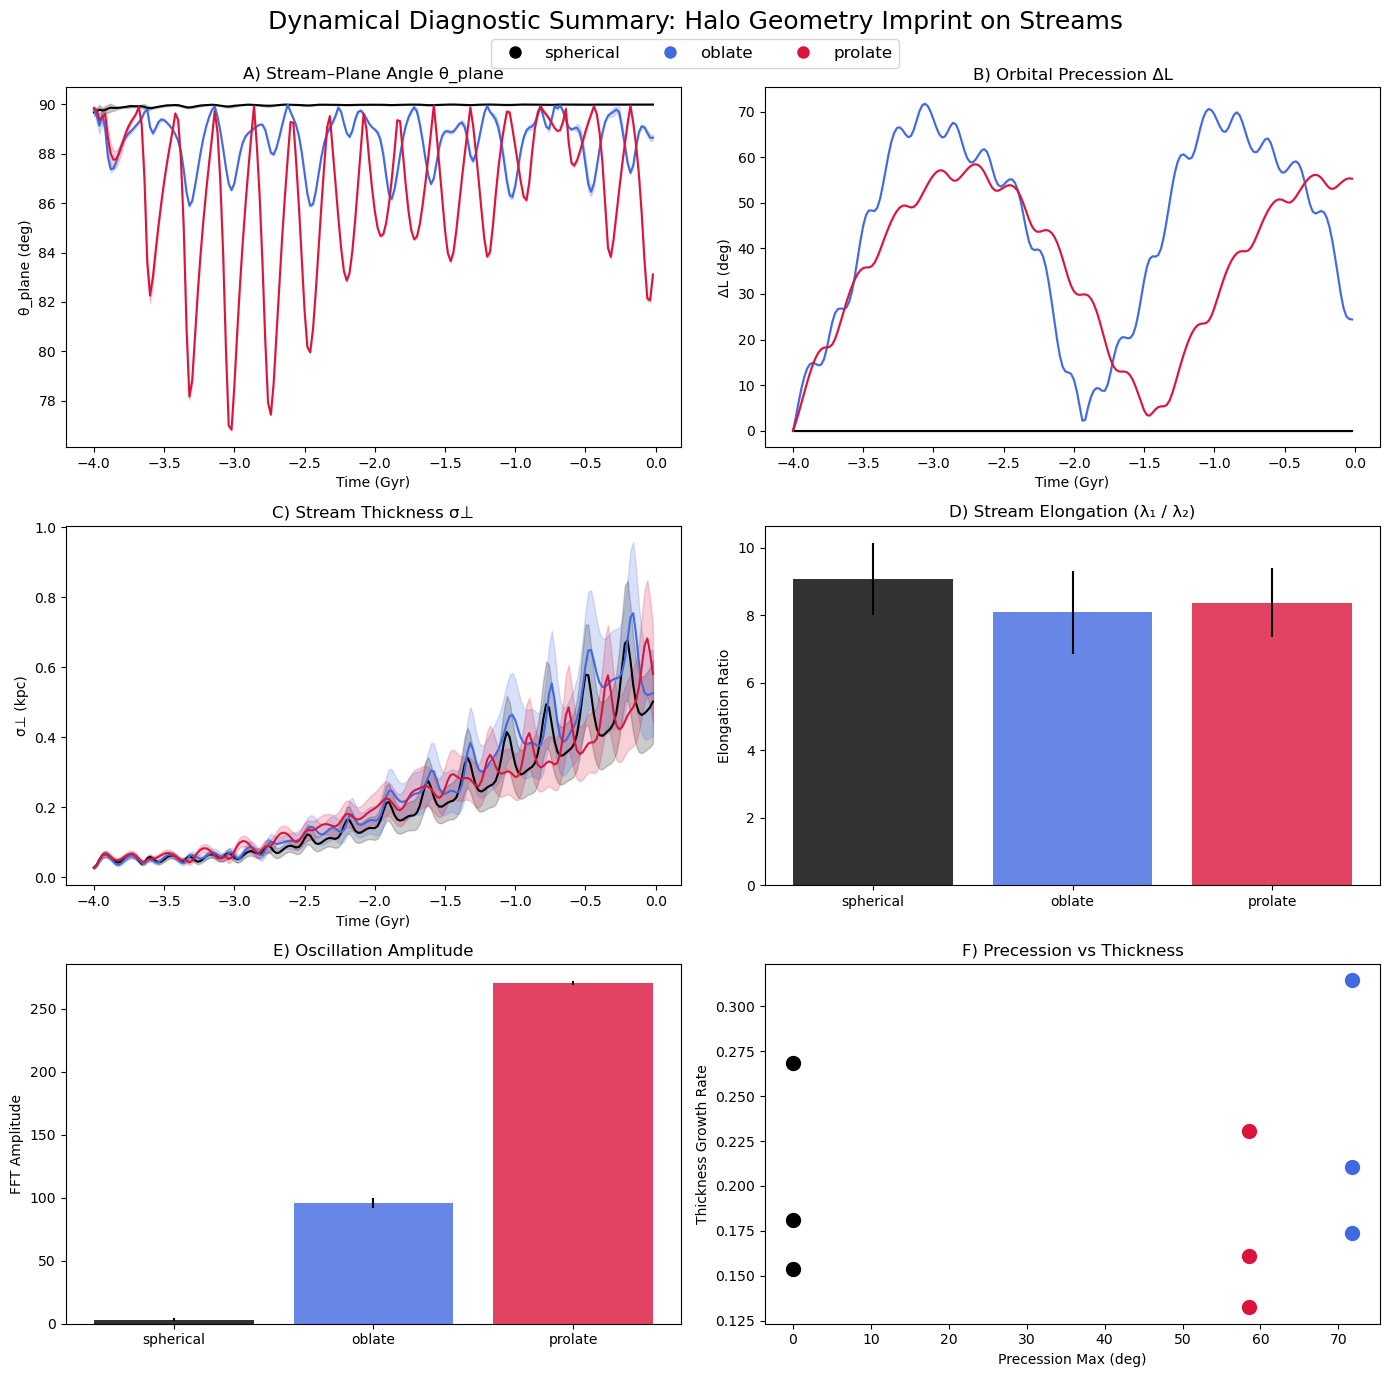

In [31]:
halos = ["spherical", "oblate", "prolate"]
colors = {
    "spherical": "black",
    "oblate": "royalblue",
    "prolate": "crimson"
}

# def ensemble_curve(df, halo, key):
#     subset = df[df.halo == halo]
#     curves = np.vstack(subset[key].values)
#     mean = curves.mean(axis=0)
#     std = curves.std(axis=0)
#     time = subset["time_Gyr"].values[0]
#     return time, mean, std


fig, axes = plt.subplots(3, 2, figsize=(14, 14))
axes = axes.flatten()

# ==========================================
# A) Stream–Plane Angle
# ==========================================
ax = axes[0]
for halo in halos:
    t, mean, std = StatisticalDiagnostics.ensemble_curve(df, halo, "theta_plane")
    ax.plot(t, mean, color=colors[halo])
    ax.fill_between(t, mean-std, mean+std,
                    color=colors[halo], alpha=0.2)

ax.set_title("A) Stream–Plane Angle θ_plane")
ax.set_ylabel("θ_plane (deg)")
ax.set_xlabel("Time (Gyr)")

# ==========================================
# B) Orbital Plane Precession
# ==========================================
ax = axes[1]
for halo in halos:
    t, mean, std = StatisticalDiagnostics.ensemble_curve(df, halo, "delta_L")
    ax.plot(t, mean, color=colors[halo])
    ax.fill_between(t, mean-std, mean+std,
                    color=colors[halo], alpha=0.2)

ax.set_title("B) Orbital Precession ΔL")
ax.set_ylabel("ΔL (deg)")
ax.set_xlabel("Time (Gyr)")

# ==========================================
# C) Thickness Evolution
# ==========================================
ax = axes[2]
for halo in halos:
    t, mean, std = StatisticalDiagnostics.ensemble_curve(df, halo, "sigma_perp")
    ax.plot(t, mean, color=colors[halo])
    ax.fill_between(t, mean-std, mean+std,
                    color=colors[halo], alpha=0.2)

ax.set_title("C) Stream Thickness σ⊥")
ax.set_ylabel("σ⊥ (kpc)")
ax.set_xlabel("Time (Gyr)")

# ==========================================
# D) Elongation Ratio
# ==========================================
ax = axes[3]
for halo in halos:
    subset = df[df.halo == halo]
    elong_mean = subset["elongation_ratio"].mean()
    elong_std = subset["elongation_ratio"].std()
    ax.bar(halo, elong_mean,
           yerr=elong_std,
           color=colors[halo],
           alpha=0.8)

ax.set_title("D) Stream Elongation (λ₁ / λ₂)")
ax.set_ylabel("Elongation Ratio")

# ==========================================
# E) Oscillation Amplitude
# ==========================================
ax = axes[4]
for halo in halos:
    subset = df[df.halo == halo]
    amp_mean = subset["oscillation_amp"].mean()
    amp_std = subset["oscillation_amp"].std()
    ax.bar(halo, amp_mean,
           yerr=amp_std,
           color=colors[halo],
           alpha=0.8)

ax.set_title("E) Oscillation Amplitude")
ax.set_ylabel("FFT Amplitude")

# ==========================================
# F) Precession vs Thickness (Phase Space)
# ==========================================
ax = axes[5]
for halo in halos:
    subset = df[df.halo == halo]
    ax.scatter(
        subset["precession_max"],
        subset["thickness_slope"],
        color=colors[halo],
        s=100,
        label=halo
    )

ax.set_title("F) Precession vs Thickness")
ax.set_xlabel("Precession Max (deg)")
ax.set_ylabel("Thickness Growth Rate")

handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=colors[h], markersize=10, label=h)
    for h in halos
]
fig.legend(handles=handles, loc="upper center",
           ncol=3, fontsize=12, bbox_to_anchor=(0.5, 0.965),)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Dynamical Diagnostic Summary: Halo Geometry Imprint on Streams",
             fontsize=18)

# plt.savefig('../figures/dynamic_metric_summary', dpi=140)
# plt.close()

## 03. More exploratory plots :

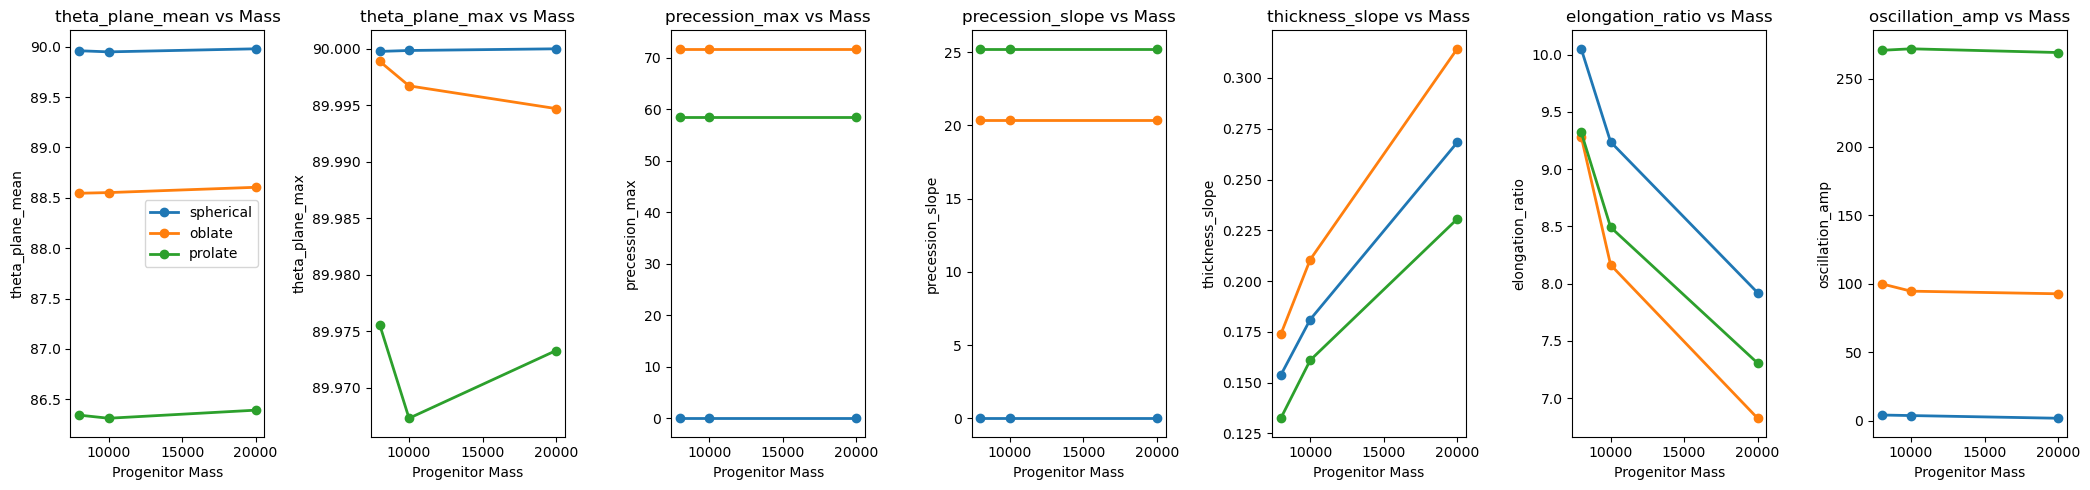

In [24]:
#metrics = ["precession_max", "theta_plane_mean", "thickness_slope"]
metrics = [
    "theta_plane_mean",
     "theta_plane_max",
    "precession_max",
    "precession_slope",
    "thickness_slope",
    "elongation_ratio",
    "oscillation_amp"
]
fig, axes = plt.subplots(1, len(metrics), figsize=(21, 5))

for ax, metric in zip(axes, metrics):

    for halo in df.halo.unique():
        subset = df[df.halo == halo].sort_values("mass")

        ax.plot(
            subset["mass"],
            subset[metric],
            marker="o",
            linewidth=2,
            label=halo
        )

    ax.set_xlabel("Progenitor Mass")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} vs Mass")

axes[0].legend()
plt.tight_layout()
# plt.savefig('../figures/dynamic_metric_vs_proginetor_mass', dpi=140)
# plt.close()

Text(0.5, 1.0, 'Metric Space PCA')

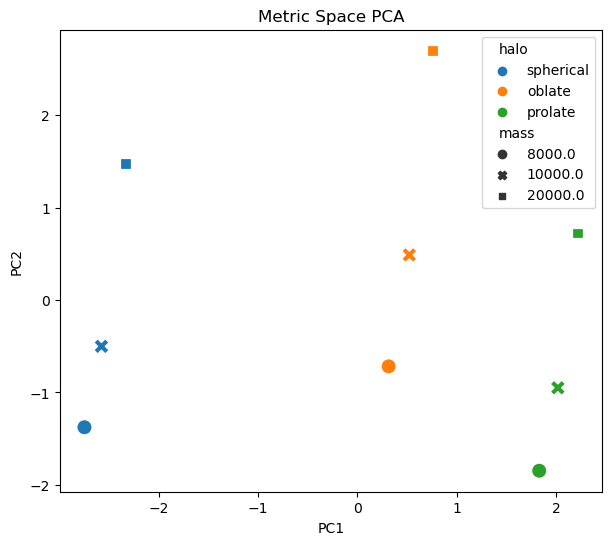

In [25]:
# feature_cols = [
#     "theta_plane_mean",
#     "precession_max",
#     "thickness_slope",
#     "oscillation_amp",
#     "elongation_ratio"
# ]

feature_cols = [
    "theta_plane_mean",
     #"theta_plane_max",
    "precession_max",
    "precession_slope",
    "thickness_slope",
    "elongation_ratio",
    "oscillation_amp"
]

X = df[feature_cols].values
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["PC1"] = X_pca[:,0]
df["PC2"] = X_pca[:,1]

plt.figure(figsize=(7,6))
sns.scatterplot(data=df, x="PC1", y="PC2", hue="halo", style="mass", s=120)
plt.title("Metric Space PCA")
# plt.savefig('../figures/dynamic_principal_component_clustering_of_all_metrics', dpi=140)
# plt.close()

Text(0.5, 1.0, 'Metric Correlation Matrix')

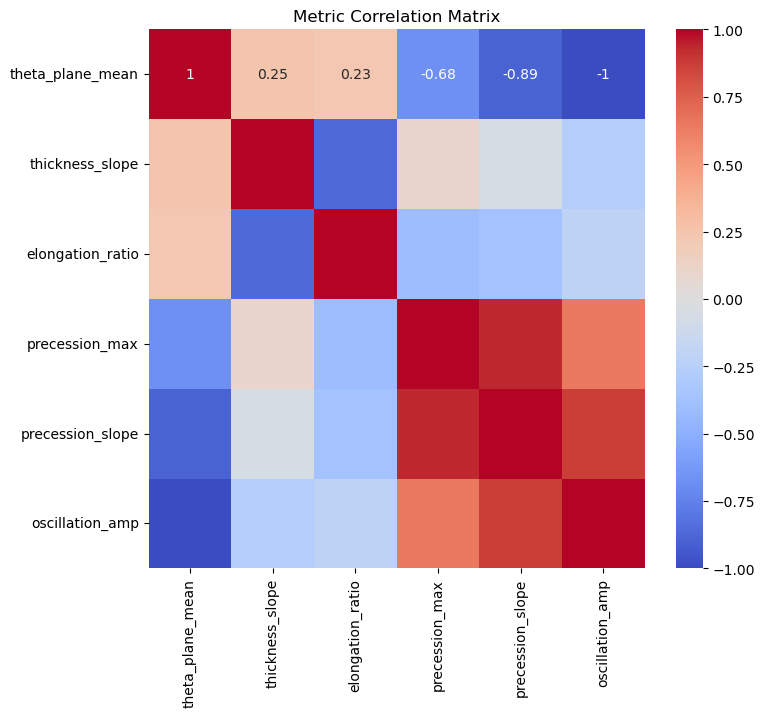

In [27]:
feature_cols = [
    "theta_plane_mean",
    #  "theta_plane_max",
    "thickness_slope",
    "elongation_ratio",
    "precession_max",
    "precession_slope",
    "oscillation_amp"
]

plt.figure(figsize=(8,7))
sns.heatmap(df[feature_cols].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Metric Correlation Matrix")
# plt.savefig('../figures/dynamic_Metric Correlation Matrix', dpi=140)
# plt.close()

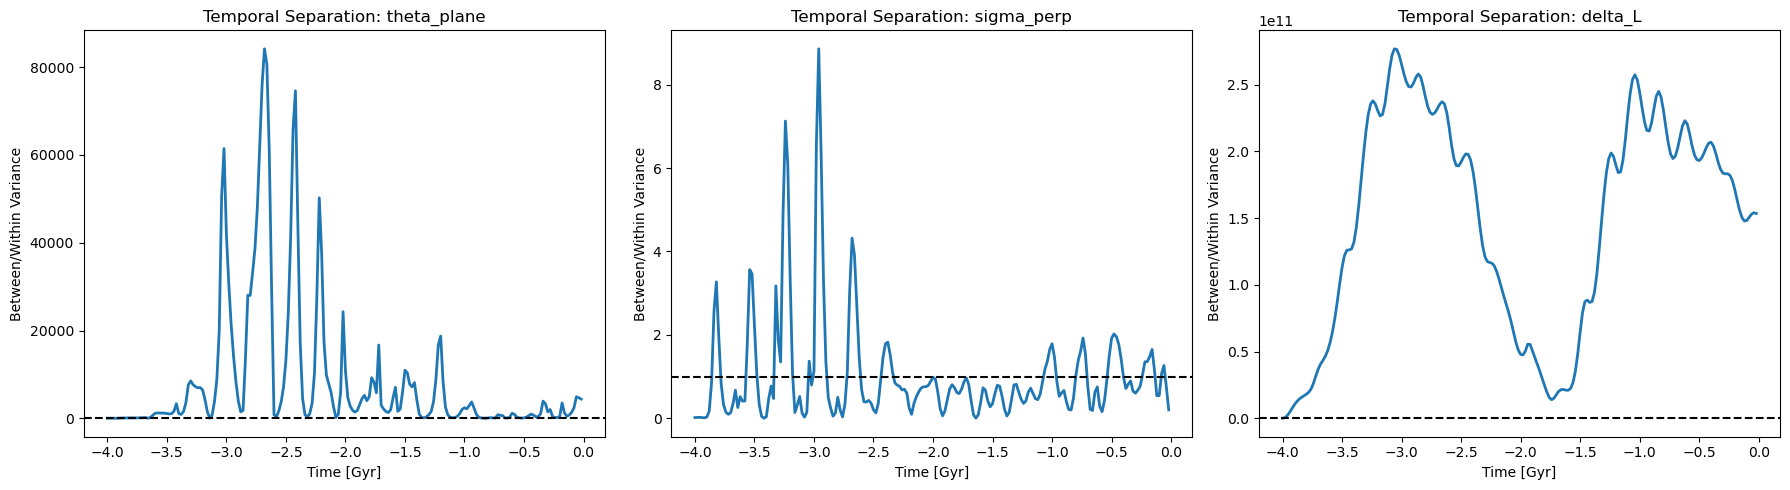

In [36]:
halos = df.halo.unique() #[0:1]
t = df.iloc[0]["time_Gyr"]   # common time grid
nt = len(t)

def compute_temporal_variance_ratio(metric_name):

    # Collect curves
    curves = {halo: [] for halo in halos}

    for _, row in df.iterrows():
        curves[row["halo"]].append(row[metric_name])

    # Convert to arrays
    for halo in halos:
        curves[halo] = np.vstack(curves[halo])  # shape: (n_mass, nt)

    R_t = np.zeros(nt)

    for i in range(nt):

        # Means per halo at time i
        halo_means = []
        halo_vars = []

        for halo in halos:
            vals = curves[halo][:, i]
            halo_means.append(np.mean(vals))
            halo_vars.append(np.var(vals))

        grand_mean = np.mean(halo_means)

        between = np.sum((np.array(halo_means) - grand_mean)**2)
        within = np.mean(halo_vars)

        R_t[i] = between / (within + 1e-8)

    return R_t


metrics = ["theta_plane", "sigma_perp", "delta_L"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, metric in zip(axes, metrics):

    R_t = compute_temporal_variance_ratio(metric)

    ax.plot(t, R_t, linewidth=2)
    ax.axhline(1, linestyle="--", color="black")
    ax.set_title(f"Temporal Separation: {metric}")
    ax.set_xlabel("Time [Gyr]")
    ax.set_ylabel("Between/Within Variance")

plt.tight_layout()
# plt.savefig('../figures/dynamic_cross_halo_temporal_separation_map', dpi=140)
# plt.close()

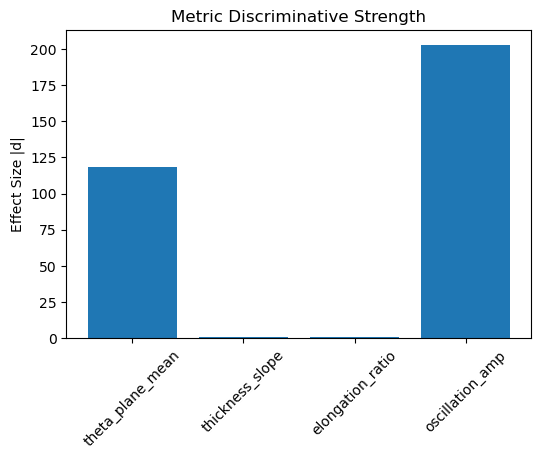

In [29]:
plt.figure(figsize=(6,4))
plt.bar(pairwise_df['metric'].loc[pairwise_df['cohens_d']!=np.inf], pairwise_df['cohens_d'].loc[pairwise_df['cohens_d']!=np.inf])
plt.xticks(rotation=45)
plt.ylabel("Effect Size |d|")
plt.title("Metric Discriminative Strength")
plt.show()

## 📘 Project Summary — Dynamical Imprints of Halo Geometry in Stellar Streams

🎯 Scientific Goal

This notebook investigates whether stellar stream evolution encodes dark matter halo geometry.

We simulated:
	•	9 globular cluster streams
	•	3 halo shapes: spherical, oblate, prolate
	•	3 progenitor masses per halo
	•	Identical initial phase-space conditions

The objective:

Determine whether halo flattening leaves measurable dynamical signatures in stream structure.

⸻

🔬 Methodology

Rather than relying on static geometric quantities, we focused on dynamical diagnostics that directly probe orbital structure:

1️⃣ Stream–Plane Alignment

Angle between the stream principal axis (via PCA) and the orbital angular momentum vector:

$\theta_{\rm plane}(t)
= \cos^{-1}\left(|\hat e_{\rm PCA} \cdot \hat L|\right)$

This measures whether the stream remains confined to its orbital plane.

⸻

2️⃣ Orbital Plane Precession

Evolution of the angular momentum direction:

$\Delta L(t)
= \cos^{-1}\left(\hat L(t) \cdot \hat L(0)\right)$

This directly probes halo-induced orbital precession.

⸻

3️⃣ Stream Thickness Evolution

Perpendicular dispersion:

$\sigma_\perp(t)$

Flattened halos induce anisotropic shear, affecting thickness growth rates.

⸻

4️⃣ Oscillation Structure

Fourier amplitude of stream–plane misalignment evolution, probing orbital frequency structure.

⸻

📊 Key Results

🔵 Orbital Precession — Strong Halo Discriminator
	•	Spherical halos: negligible precession
	•	Oblate halos: large secular precession (70 degrees)
	•	Prolate halos: significant precession (60 degrees)

Statistical tests:
	•	ANOVA: highly significant
	•	Variance ratio: extremely large
	•	Effect size (Cohen’s d): very large

Orbital plane precession cleanly separates halo geometries.

⸻

🔵 Stream–Plane Misalignment

Mean values show systematic ordering:

$\theta_{\rm plane}^{\rm spherical}$
$>$
$\theta_{\rm plane}^{\rm oblate}$
$>$
$\theta_{\rm plane}^{\rm prolate}$

Flattened halos tilt streams away from their original orbital plane.

Effect sizes are large and robust across progenitor masses.

⸻

🔵 Oscillation Amplitude

Flattened halos significantly enhance oscillatory structure in stream orientation evolution:
	•	Spherical: weak oscillations
	•	Oblate: strong
	•	Prolate: very strong

This reflects modifications to orbital frequency structure.

⸻

🔵 Thickness Growth

Thickness growth shows moderate halo sensitivity but is weaker than precession-based diagnostics.

⸻

🧠 Physical Interpretation

Halo flattening alters the gravitational potential symmetry, leading to:
	•	Orbital plane precession
	•	Modified frequency gradients
	•	Long-term geometric tilting of streams
	•	Enhanced oscillatory structure

These effects accumulate dynamically over time.

The strongest halo signal is not static geometry, but orbital evolution.

⸻

📈 Physics Summary Figure

The final 6-panel diagnostic figure shows:

A — Stream–plane angle evolution
B — Orbital precession ΔL(t)
C — Thickness growth
D — Elongation ratio
E — Oscillation amplitude
F — Phase portrait in metric space

Together they demonstrate systematic divergence between spherical and flattened halos.

⸻

📊 Statistical Summary

Strong halo discriminators:
	•	Precession amplitude
	•	Precession slope
	•	Oscillation amplitude
	•	Mean stream–plane angle

Moderate/weak:
	•	Thickness growth
	•	Elongation ratio

Variance ratios and effect sizes confirm robust separation for dynamical metrics.

⸻

🏁 Final Conclusion

For the orbit and halo regime explored:

#### Orbital plane evolution provides a clear and statistically robust diagnostic of halo geometry.

Halo flattening leaves measurable dynamical imprints in:
	•	Angular momentum evolution
	•	Stream–plane alignment
	•	Oscillatory frequency structure

These signatures are consistent across progenitor masses.
